<a href="https://colab.research.google.com/github/Gaurav55ks/Encryptix/blob/main/Generating_Word_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install tesseract-ocr -y > /dev/null 2>&1
!pip install pytesseract > /dev/null 2>&1

In [2]:
# Importing Libraries
import os
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from timeit import default_timer as timer
import cv2
import pytesseract
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader,random_split
from torchvision import transforms, datasets

In [3]:
from google.colab import files
files.upload()
!kaggle datasets download -d naderabdalghani/iam-handwritten-forms-dataset > /dev/null 2>&1
!unzip iam-handwritten-forms-dataset.zip -d iam-handwritten-forms-dataset > /dev/null 2>&1

Saving kaggle.json to kaggle.json


In [4]:
## Function to go through the files.
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
# walk_through_dir("/content/iam-handwritten-forms-dataset")

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
path = Path("/content/iam-handwritten-forms-dataset")
data_path = path/"data"

Random Image Path : /content/iam-handwritten-forms-dataset/data/217/g01-000.png
Image Class : 217
Image Height : 3542
Image Width : 2479


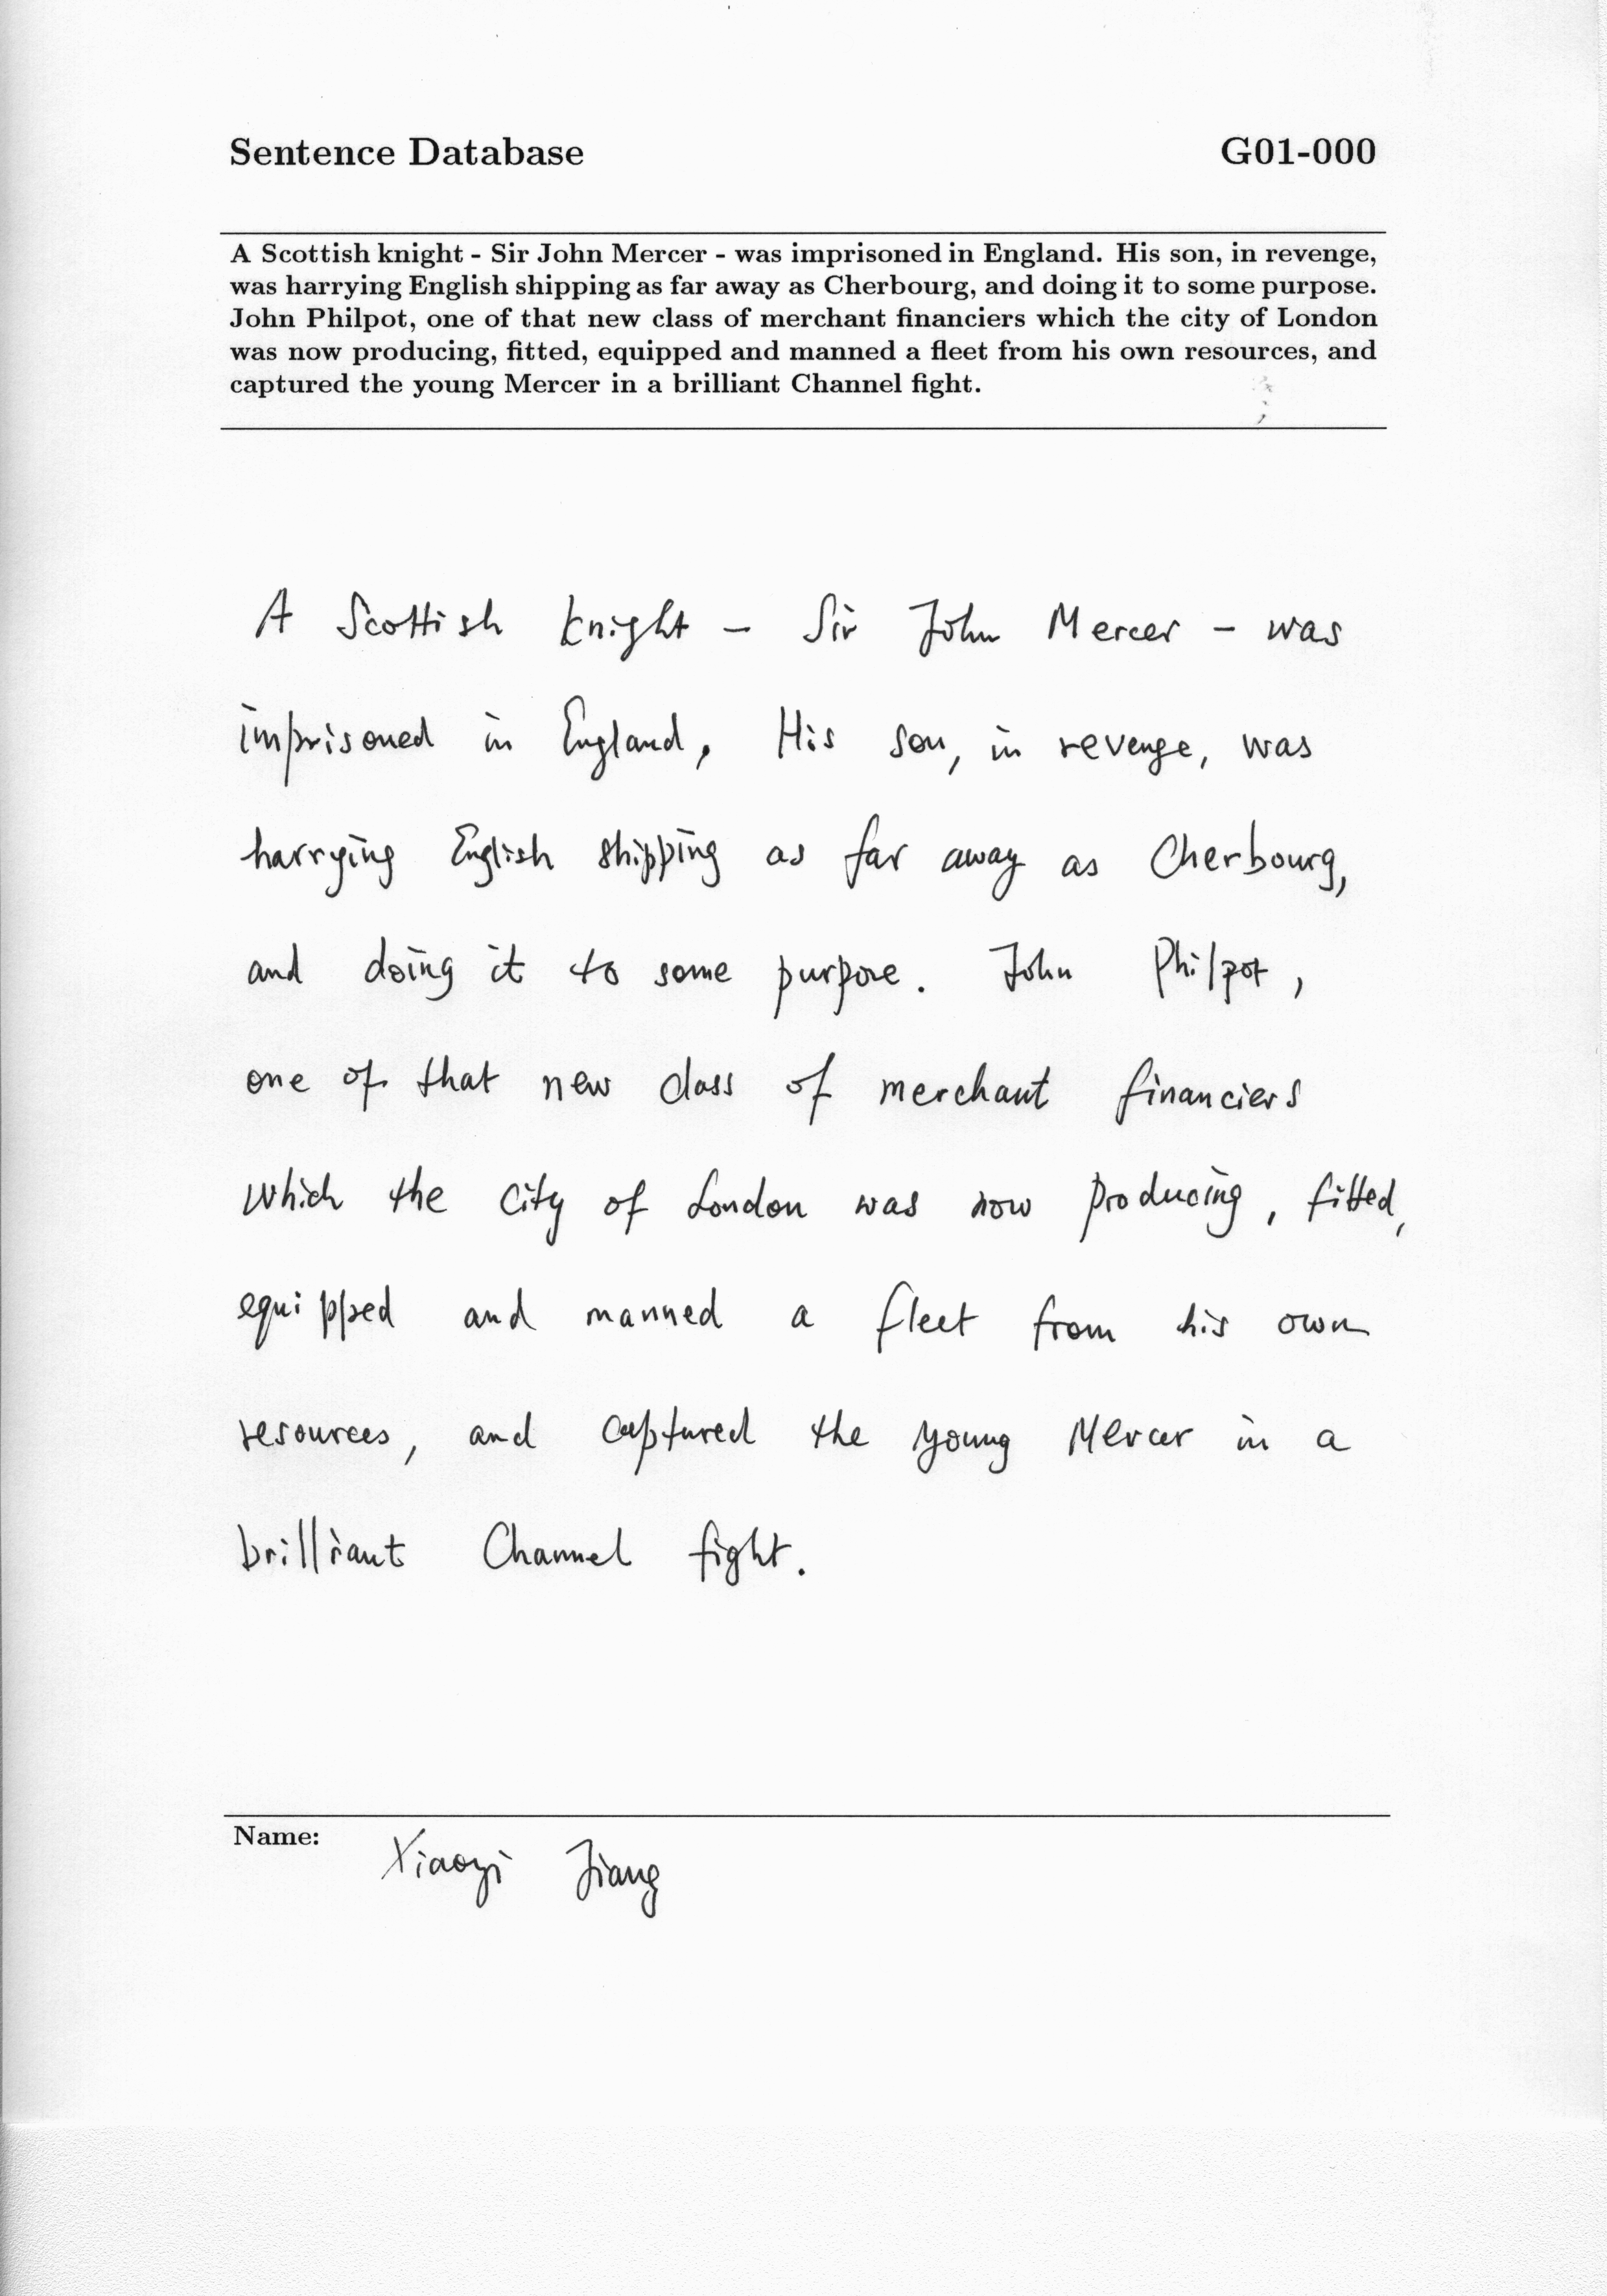

In [8]:
image_path_list = list(data_path.glob("*/*"))
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random Image Path : {random_image_path}")
print(f"Image Class : {image_class}")
print(f"Image Height : {img.height}")
print(f"Image Width : {img.width}")
img

In [9]:
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
image_transforms

Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

In [10]:
def plot_transformed_image(image_paths,transform,n=3,seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig,ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Size : {f.size}")
            ax[0].axis(False)
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nsize : {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class : {image_path.parent.stem}",fontsize = 16)

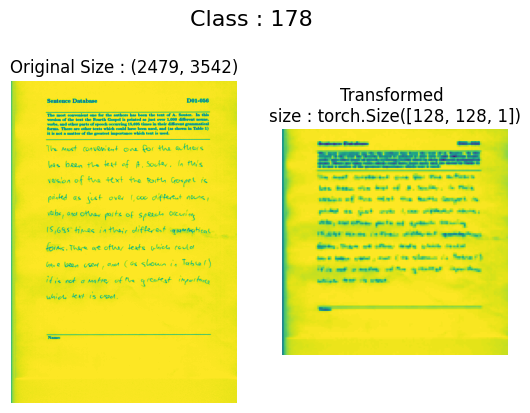

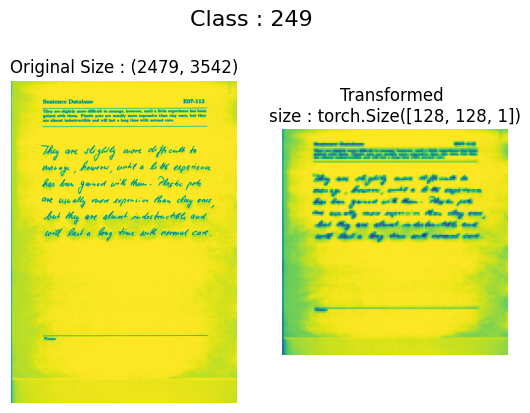

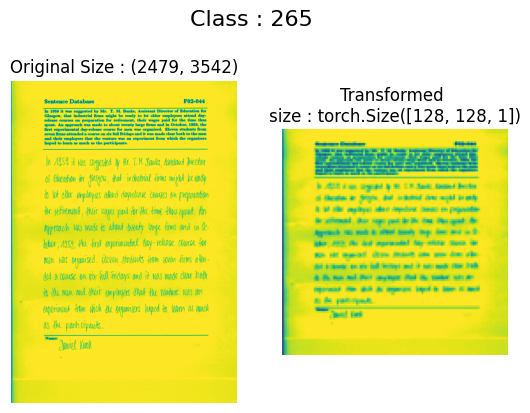

In [11]:
plot_transformed_image(image_path_list,image_transforms)

In [12]:
train_data = datasets.ImageFolder(root = data_path,
                                 transform = image_transforms,
                                 target_transform = None)
train_data

Dataset ImageFolder
    Number of datapoints: 1539
    Root location: /content/iam-handwritten-forms-dataset/data
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [13]:
## Splitting Data for Faster Experiment.
"""subset_size = 250
dataset_size = len(train_data)

if subset_size > dataset_size:
    subset_size = dataset_size

# Split the dataset into subset and remaining
subset, _ = random_split(train_data, [subset_size, dataset_size - subset_size])
"""

'subset_size = 250\ndataset_size = len(train_data)\n\nif subset_size > dataset_size:\n    subset_size = dataset_size\n\n# Split the dataset into subset and remaining\nsubset, _ = random_split(train_data, [subset_size, dataset_size - subset_size])\n'

In [14]:
val_size = int(0.2 * len(train_data))  # 20% of the data for validation
train_size = len(train_data) - val_size

train_subset, val_subset = random_split(train_data, [train_size, val_size])

In [15]:
len(train_subset) , len(val_subset)

(1232, 307)

In [16]:
## Creating DataLoaders
train_dataloader = DataLoader(dataset = train_subset,
                             batch_size = 32,
                             shuffle=True,
                             num_workers = os.cpu_count())
val_dataloader = DataLoader(dataset = val_subset,
                           batch_size = 32,
                           shuffle = False,
                           num_workers = os.cpu_count())

train_dataloader , val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b491c1fa980>,
 <torch.utils.data.dataloader.DataLoader at 0x7b491c1fa590>)

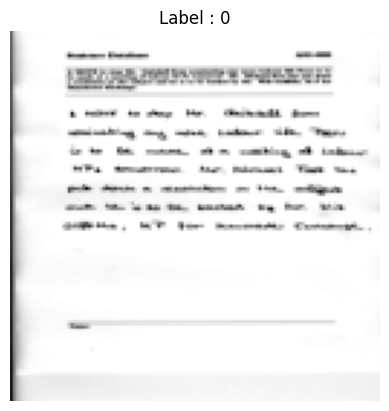

In [17]:
image,label = train_data[0]
plt.imshow(transforms.ToPILImage()(image),cmap="gray")
plt.title(f"Label : {label}")
plt.axis(False)
plt.show()

In [18]:
## Creating Preprocess_image to improve image quality before extracting text
def preprocess_image(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')

    image_array = np.array(image)

    gray_image = cv2.cvtColor(image_array,cv2.COLOR_RGB2GRAY)

    _,thresh_image = cv2.threshold(gray_image,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresh_image

def extract_text_from_image(image):
    preprocessed_image = preprocess_image(image)
    pil_image = Image.fromarray(preprocessed_image)
    text = pytesseract.image_to_string(pil_image,config='--psm 11')
    return text.strip()

In [19]:
image_path_list = list(data_path.glob("*/*"))
random_image_path = random.choice(image_path_list)
image = Image.open(random_image_path)

extracted_text = extract_text_from_image(image)
print(f"Extracted Image : {extracted_text}")

Extracted Image : Sentence Database

C06-091

boredom. The film is funny enough in places and has a line or two of painful home

It’s hereabouts that the budge takes to the bottle, but I don’t think it was through

truths thrown in. ”I don’t want to talk like an adult,” screams Gina, walking out on

the man who has so far failed to make an honest woman of her

Ls hawabouf bik Ye bi

fala to te beh, fod 1

bot thick if 1400 soph beondowr The hb Lo foun crougl

Jn ple: tnd faa 0 yee Or ho of pated bp Cnt hcl.

fom ot "Tabu t tant bo hh bbe tn

“onan

a walle 7, hell ged on hha

Name

[At


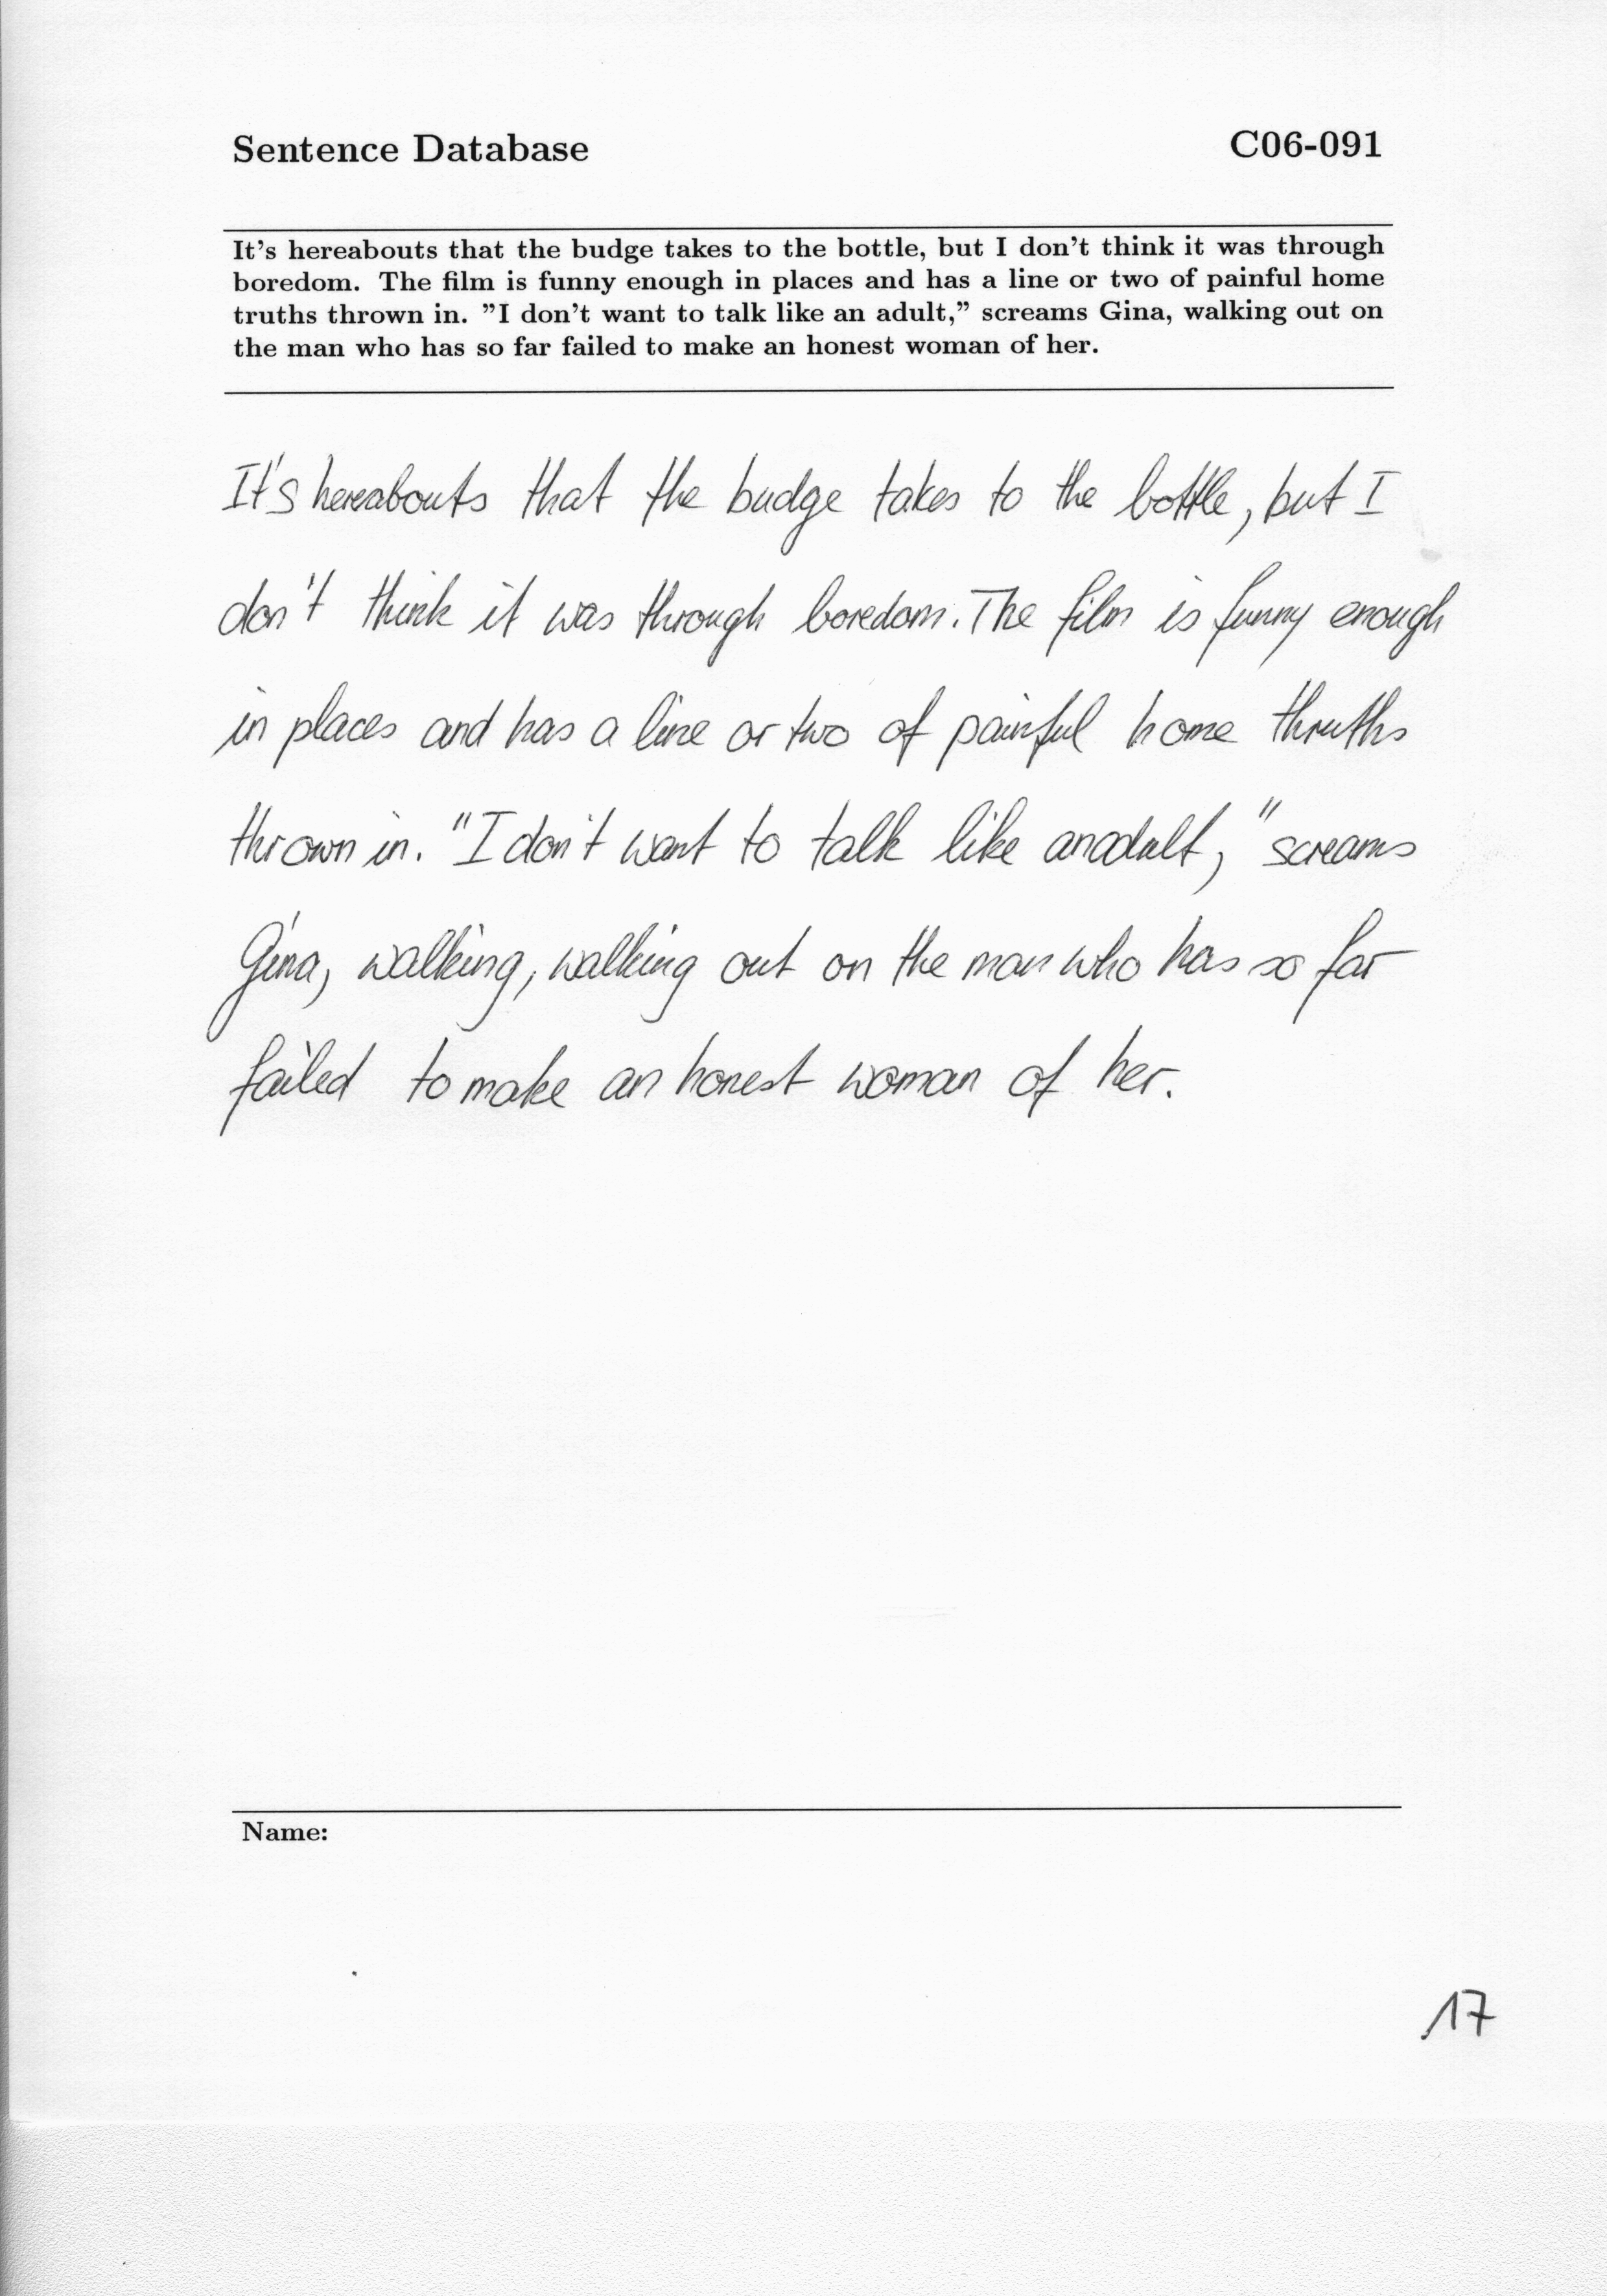

In [20]:
image

In [21]:
## HandWritingRNN class
class HandWritingRNN(nn.Module):
    def __init__(self,
                input_shape : int,
                hidden_units : int,
                output_shape : int,
                num_layers : int = 1):
        super(HandWritingRNN,self).__init__()
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.RNN = nn.LSTM(input_shape,
                          hidden_units,
                          num_layers,
                          batch_first = True)
        self.FC = nn.Linear(hidden_units,
                           output_shape)
    def forward(self,x,hidden):
        out,hidden = self.RNN(x,hidden)
        out = self.FC(out)
        return out,hidden

    def init_hidden(self,batch_size,device):
        return (torch.zeros(self.num_layers,batch_size,self.hidden_units,device = device),
               torch.zeros(self.num_layers,batch_size,self.hidden_units,device = device))

In [22]:
def train_step(model :torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              optimizer : torch.optim.Optimizer,
              device : torch.device):
    model.train()
    train_loss = 0.0

    for X,_ in dataloader:
        X = X.to(device)

        batch_size,channels,height,width = X.size()
        X = X.view(batch_size,-1) # Flatting Image
        X = X.unsqueeze(1) # Adding Sequence Dimension

        hidden = model.init_hidden(X.size(0),device)

        optimizer.zero_grad()

        outputs, _ = model(X,hidden)

        outputs = outputs.squeeze(1)
        targets = X.view(X.size(0),-1) # flatting the targets

        loss = loss_fn(outputs , targets)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss / len(dataloader)

In [23]:
def test_step(model : torch.nn.Module,
             dataloader : torch.utils.data.DataLoader,
             loss_fn : torch.nn.Module,
             device = torch.device):
    model.eval()
    test_loss = 0.0
    with torch.inference_mode():
        for X,_ in dataloader:
            X = X.to(device)

            batch_size,channels,height,width = X.size()
            X = X.view(batch_size,-1)
            X = X.unsqueeze(1)

            hidden = model.init_hidden(X.size(0),device)

            outputs, _ = model(X, hidden)

            # Flatten outputs and targets
            outputs = outputs.squeeze(1)  # Remove sequence dimension
            targets = X.view(X.size(0), -1)  # Flatten targets

            loss = loss_fn(outputs, targets)
            test_loss += loss.item()
    return test_loss / len(dataloader)

In [24]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          device: torch.device,
          epochs: int = 5):
    model.to(device)
    results = {"train_loss": [],
               "val_loss": []}

    for epoch in range(epochs):
        train_loss = train_step(model, train_dataloader, loss_fn, optimizer, device)
        val_loss = test_step(model, val_dataloader, loss_fn, device)

        print(f"Epoch: {epoch + 1} | train_loss: {train_loss:.3f} | val_loss: {val_loss:.3f}")
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

    return results


In [25]:
input_shape = 128*128
output_shape = input_shape
hidden_units = 256
num_layers = 2
model = HandWritingRNN(input_shape = input_shape,
                      output_shape = output_shape,
                      hidden_units = hidden_units,
                      num_layers = num_layers)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

model_results = train(model, train_dataloader, val_dataloader, optimizer, loss_fn, epochs=5, device=device)

end_time = timer()

print(f"Total Training Time : {end_time - start_time:.3f}seconds")

Epoch: 1 | train_loss: 0.132 | val_loss: 0.014
Epoch: 2 | train_loss: 0.010 | val_loss: 0.009
Epoch: 3 | train_loss: 0.009 | val_loss: 0.009
Epoch: 4 | train_loss: 0.009 | val_loss: 0.010
Epoch: 5 | train_loss: 0.009 | val_loss: 0.010
Total Training Time : 598.414seconds


In [26]:
## For Better Accuracy
def sample(predictions, temperature=1.0):
    predictions = predictions / temperature
    probabilities = F.softmax(predictions, dim=-1)
    return torch.multinomial(probabilities, 1).item()

In [27]:
def generate_text(model, seed_text, max_length, device, temperature=1.0):
    model.eval()
    generated_text = seed_text

    # Converting Textv into tensor
    seed_tensor = torch.tensor([ord(char) for char in seed_text], dtype=torch.float32).unsqueeze(0).to(device)

    if seed_tensor.size(-1) < 16384:
        padding_size = 16384 - seed_tensor.size(-1)
        seed_tensor = F.pad(seed_tensor, (0, padding_size), 'constant', 0)
    else:
        seed_tensor = seed_tensor[:, :16384]

    seed_tensor = seed_tensor.unsqueeze(1)

    hidden = model.init_hidden(seed_tensor.size(0), device)

    with torch.no_grad():
        for _ in range(max_length):
            output, hidden = model(seed_tensor, hidden)

            output = output.squeeze(1)
            predictions = output[-1]

            predicted_char_index = sample(predictions, temperature)
            predicted_char = chr(predicted_char_index)
            generated_text += predicted_char

            # Update seed tensor with the new character
            new_char_tensor = torch.tensor([ord(predicted_char)], dtype=torch.float32).unsqueeze(0).to(device)
            new_char_tensor = F.pad(new_char_tensor, (0, 16384 - new_char_tensor.size(-1)), 'constant', 0)
            new_char_tensor = new_char_tensor.unsqueeze(1)

            # Slide the window to include the new character
            seed_tensor = torch.cat((seed_tensor[:, 1:, :], new_char_tensor), dim=1)

    return generated_text

In [28]:
seed_text = extracted_text
max_length = 100
temperature = 0.8
model.to(device)
generated_text = generate_text(model, seed_text, max_length, device)
print(f"Generated text: \n{generated_text}")

Generated text: 
Sentence Database

C06-091

boredom. The film is funny enough in places and has a line or two of painful home

It’s hereabouts that the budge takes to the bottle, but I don’t think it was through

truths thrown in. ”I don’t want to talk like an adult,” screams Gina, walking out on

the man who has so far failed to make an honest woman of her

Ls hawabouf bik Ye bi

fala to te beh, fod 1

bot thick if 1400 soph beondowr The hb Lo foun crougl

Jn ple: tnd faa 0 yee Or ho of pated bp Cnt hcl.

fom ot "Tabu t tant bo hh bbe tn

“onan

a walle 7, hell ged on hha

Name

[At㓌㹹⼉㖾⭱ഀ㩐ᝁ቟ʔ៿ᐭƎ㮕㠆㉚㪓㠼ㆹ⪿฀∥✅ᠣ❍㭦㕡㰮⍾㛌Ⲿ✩᎛㳎Υෛն⭊㓍⃾⏈٣ᘜڱ⬻㣾㟢㕛᠎͞㚕㌭㢐ᵨϏ܋᳓㫌○ᆲย㊨ުㇾ᭿㟵അᥦ႔૧⊆ᣱŻ׷せ✺㦛⦮㩢↉⵭₆㦓જ⚶ص̺㭌⮒Щѿუ╛ᚋ⬈᧏╟⎌⑘᪼
